In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU usage

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import MinMaxScaler
import pickle
%matplotlib inline

In [9]:
# Read data
filepath = "../experimental_data/averaged_data.csv"
dataset = pd.read_csv(filepath, sep=",")
dataset.head()

,ch4_flow,t_center,nc,sc,m_Ni,ch4,h2,co2,co
0,50.0,600.0,3.0,3.0,0.174717,0.222502,0.610076,0.106240,0.061156
1,50.0,625.0,3.0,3.0,0.174717,0.181560,0.640715,0.103638,0.074178
2,35.0,625.0,4.0,5.0,0.174717,0.127106,0.684178,0.118278,0.070438
3,47.0,625.0,0.5,6.0,0.174717,0.137173,0.676770,0.132200,0.053858
4,50.0,625.0,2.0,4.0,0.174717,0.167882,0.652580,0.116762,0.062776


In [6]:
X = dataset.loc[:, :"m_Ni"].values
Y = dataset.loc[:, "ch4":].values

# Scale data 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=0)

In [8]:
model_name = "network"
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
# early_stopping_monitor = EarlyStopping(patience=10)
loss = "mae"
metrics = ["mape"]
epochs = 5000

network = Sequential([
    Dense(25, activation=tf.nn.relu, input_shape=(5,)),
    Dense(20, activation=tf.nn.relu),
    Dense(15, activation=tf.nn.relu),
    Dense(10, activation=tf.nn.relu),
    Dense( 4, activation=tf.nn.sigmoid)
])

network.compile(loss=loss, optimizer=optimizer, metrics=metrics)
hist = network.fit(X_train, Y_train, batch_size=X_train.shape[0], epochs=epochs, verbose=1,
                 validation_data=(X_test, Y_test), shuffle=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 778 samples, validate on 195 samples
Epoch 1/5000
778/778 [==============================] - 0s 242us/sample - loss: 0.2829 - mean_absolute_percentage_error: 729.9388 - val_loss: 0.2773 - val_mean_absolute_percentage_error: 780.7939
Epoch 2/5000
778/778 [==============================] - 0s 13us/sample - loss: 0.2813 - mean_absolute_percentage_error: 727.0739 - val_loss: 0.2764 - val_mean_absolute_percentage_error: 776.3095
Epoch 3/5000
778/778 [==============================] - 0s 16us/sample - loss: 0.2805 - mean_absolute_percentage_error: 723.1321 - val_loss: 0.2758 - val_mean_absolute_percentage_error: 774.3394
Epoch 4/5000
778/778 [==============================] - 0s 12us/sample - loss: 0.2798 - mean_absolute_percentage_error: 721.1710 - val_loss: 0.2753 - val_mean_absolute_percentage_error: 772.1141
Epoch 5/5000
778/778 [==============================] -

Epoch 41/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.2552 - mean_absolute_percentage_error: 659.5234 - val_loss: 0.2500 - val_mean_absolute_percentage_error: 702.6193
Epoch 42/5000
778/778 [==============================] - 0s 10us/sample - loss: 0.2542 - mean_absolute_percentage_error: 657.2198 - val_loss: 0.2490 - val_mean_absolute_percentage_error: 700.0428
Epoch 43/5000
778/778 [==============================] - 0s 10us/sample - loss: 0.2531 - mean_absolute_percentage_error: 654.8809 - val_loss: 0.2479 - val_mean_absolute_percentage_error: 697.5293
Epoch 44/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.2520 - mean_absolute_percentage_error: 652.5138 - val_loss: 0.2468 - val_mean_absolute_percentage_error: 694.6842
Epoch 45/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.2508 - mean_absolute_percentage_error: 649.8357 - val_loss: 0.2456 - val_mean_absolute_percentage_error: 691.4982
Epoch 46/5000
778/778 [

Epoch 83/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.1944 - mean_absolute_percentage_error: 437.7468 - val_loss: 0.1899 - val_mean_absolute_percentage_error: 452.9344
Epoch 84/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.1927 - mean_absolute_percentage_error: 427.8981 - val_loss: 0.1882 - val_mean_absolute_percentage_error: 446.8940
Epoch 85/5000
778/778 [==============================] - 0s 4us/sample - loss: 0.1909 - mean_absolute_percentage_error: 422.2932 - val_loss: 0.1865 - val_mean_absolute_percentage_error: 436.7810
Epoch 86/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.1892 - mean_absolute_percentage_error: 412.9932 - val_loss: 0.1848 - val_mean_absolute_percentage_error: 430.2376
Epoch 87/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.1874 - mean_absolute_percentage_error: 406.8863 - val_loss: 0.1831 - val_mean_absolute_percentage_error: 420.3324
Epoch 88/5000
778/778 [==

Epoch 125/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.1168 - mean_absolute_percentage_error: 146.5259 - val_loss: 0.1146 - val_mean_absolute_percentage_error: 147.2479
Epoch 126/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.1153 - mean_absolute_percentage_error: 142.0578 - val_loss: 0.1131 - val_mean_absolute_percentage_error: 143.2847
Epoch 127/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.1137 - mean_absolute_percentage_error: 138.3095 - val_loss: 0.1116 - val_mean_absolute_percentage_error: 139.6340
Epoch 128/5000
778/778 [==============================] - 0s 10us/sample - loss: 0.1122 - mean_absolute_percentage_error: 134.8361 - val_loss: 0.1101 - val_mean_absolute_percentage_error: 135.7505
Epoch 129/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.1107 - mean_absolute_percentage_error: 131.1430 - val_loss: 0.1087 - val_mean_absolute_percentage_error: 132.8240
Epoch 130/5000
778/

Epoch 167/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0614 - mean_absolute_percentage_error: 75.0989 - val_loss: 0.0607 - val_mean_absolute_percentage_error: 68.3579
Epoch 168/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0606 - mean_absolute_percentage_error: 66.7743 - val_loss: 0.0596 - val_mean_absolute_percentage_error: 74.6816
Epoch 169/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0595 - mean_absolute_percentage_error: 72.7563 - val_loss: 0.0587 - val_mean_absolute_percentage_error: 66.2786
Epoch 170/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0586 - mean_absolute_percentage_error: 64.7805 - val_loss: 0.0577 - val_mean_absolute_percentage_error: 71.4304
Epoch 171/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0576 - mean_absolute_percentage_error: 69.6381 - val_loss: 0.0569 - val_mean_absolute_percentage_error: 64.2467
Epoch 172/5000
778/778 [======

Epoch 210/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0399 - mean_absolute_percentage_error: 39.0094 - val_loss: 0.0400 - val_mean_absolute_percentage_error: 40.9039
Epoch 211/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0398 - mean_absolute_percentage_error: 40.8459 - val_loss: 0.0392 - val_mean_absolute_percentage_error: 38.0090
Epoch 212/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0397 - mean_absolute_percentage_error: 38.4559 - val_loss: 0.0396 - val_mean_absolute_percentage_error: 39.9420
Epoch 213/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0395 - mean_absolute_percentage_error: 40.0198 - val_loss: 0.0389 - val_mean_absolute_percentage_error: 37.4818
Epoch 214/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0394 - mean_absolute_percentage_error: 37.9885 - val_loss: 0.0393 - val_mean_absolute_percentage_error: 39.1084
Epoch 215/5000
778/778 [======

Epoch 253/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0376 - mean_absolute_percentage_error: 33.5725 - val_loss: 0.0366 - val_mean_absolute_percentage_error: 31.0127
Epoch 254/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0374 - mean_absolute_percentage_error: 32.3343 - val_loss: 0.0374 - val_mean_absolute_percentage_error: 32.3348
Epoch 255/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0375 - mean_absolute_percentage_error: 33.3717 - val_loss: 0.0365 - val_mean_absolute_percentage_error: 30.9006
Epoch 256/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0372 - mean_absolute_percentage_error: 32.2129 - val_loss: 0.0371 - val_mean_absolute_percentage_error: 32.0307
Epoch 257/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0373 - mean_absolute_percentage_error: 33.1094 - val_loss: 0.0364 - val_mean_absolute_percentage_error: 30.8075
Epoch 258/5000
778/778 [======

Epoch 296/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0360 - mean_absolute_percentage_error: 29.6697 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 29.8868
Epoch 297/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0361 - mean_absolute_percentage_error: 31.0160 - val_loss: 0.0351 - val_mean_absolute_percentage_error: 28.1525
Epoch 298/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0359 - mean_absolute_percentage_error: 29.5824 - val_loss: 0.0360 - val_mean_absolute_percentage_error: 29.6890
Epoch 299/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0360 - mean_absolute_percentage_error: 30.8229 - val_loss: 0.0350 - val_mean_absolute_percentage_error: 28.0870
Epoch 300/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0358 - mean_absolute_percentage_error: 29.5118 - val_loss: 0.0359 - val_mean_absolute_percentage_error: 29.6241
Epoch 301/5000
778/778 [======

Epoch 339/5000
778/778 [==============================] - 0s 9us/sample - loss: 0.0350 - mean_absolute_percentage_error: 29.0687 - val_loss: 0.0340 - val_mean_absolute_percentage_error: 26.2728
Epoch 340/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0348 - mean_absolute_percentage_error: 27.7440 - val_loss: 0.0351 - val_mean_absolute_percentage_error: 27.8703
Epoch 341/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0350 - mean_absolute_percentage_error: 29.0341 - val_loss: 0.0340 - val_mean_absolute_percentage_error: 26.1439
Epoch 342/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0349 - mean_absolute_percentage_error: 27.6397 - val_loss: 0.0351 - val_mean_absolute_percentage_error: 27.8511
Epoch 343/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0350 - mean_absolute_percentage_error: 29.0067 - val_loss: 0.0340 - val_mean_absolute_percentage_error: 26.0063
Epoch 344/5000
778/778 [======

Epoch 382/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0341 - mean_absolute_percentage_error: 26.4608 - val_loss: 0.0343 - val_mean_absolute_percentage_error: 26.5172
Epoch 383/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0342 - mean_absolute_percentage_error: 27.6665 - val_loss: 0.0333 - val_mean_absolute_percentage_error: 24.9006
Epoch 384/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0341 - mean_absolute_percentage_error: 26.4258 - val_loss: 0.0343 - val_mean_absolute_percentage_error: 26.4976
Epoch 385/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0342 - mean_absolute_percentage_error: 27.6396 - val_loss: 0.0333 - val_mean_absolute_percentage_error: 24.8502
Epoch 386/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0341 - mean_absolute_percentage_error: 26.3810 - val_loss: 0.0343 - val_mean_absolute_percentage_error: 26.4654
Epoch 387/5000
778/778 [======

Epoch 425/5000
778/778 [==============================] - 0s 9us/sample - loss: 0.0337 - mean_absolute_percentage_error: 27.0123 - val_loss: 0.0329 - val_mean_absolute_percentage_error: 24.2875
Epoch 426/5000
778/778 [==============================] - 0s 9us/sample - loss: 0.0337 - mean_absolute_percentage_error: 25.8259 - val_loss: 0.0339 - val_mean_absolute_percentage_error: 25.9649
Epoch 427/5000
778/778 [==============================] - 0s 10us/sample - loss: 0.0338 - mean_absolute_percentage_error: 27.0173 - val_loss: 0.0328 - val_mean_absolute_percentage_error: 24.2564
Epoch 428/5000
778/778 [==============================] - 0s 12us/sample - loss: 0.0337 - mean_absolute_percentage_error: 25.7961 - val_loss: 0.0339 - val_mean_absolute_percentage_error: 25.9267
Epoch 429/5000
778/778 [==============================] - 0s 9us/sample - loss: 0.0337 - mean_absolute_percentage_error: 26.9796 - val_loss: 0.0328 - val_mean_absolute_percentage_error: 24.2315
Epoch 430/5000
778/778 [====

Epoch 468/5000
778/778 [==============================] - 0s 11us/sample - loss: 0.0334 - mean_absolute_percentage_error: 25.3665 - val_loss: 0.0336 - val_mean_absolute_percentage_error: 25.5227
Epoch 469/5000
778/778 [==============================] - 0s 9us/sample - loss: 0.0334 - mean_absolute_percentage_error: 26.5242 - val_loss: 0.0325 - val_mean_absolute_percentage_error: 23.7912
Epoch 470/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0334 - mean_absolute_percentage_error: 25.3425 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 25.4813
Epoch 471/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0334 - mean_absolute_percentage_error: 26.4871 - val_loss: 0.0325 - val_mean_absolute_percentage_error: 23.7741
Epoch 472/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0334 - mean_absolute_percentage_error: 25.3246 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 25.4525
Epoch 473/5000
778/778 [=====

Epoch 511/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0331 - mean_absolute_percentage_error: 26.1027 - val_loss: 0.0323 - val_mean_absolute_percentage_error: 23.4513
Epoch 512/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0330 - mean_absolute_percentage_error: 25.0047 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 24.9336
Epoch 513/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0330 - mean_absolute_percentage_error: 25.9941 - val_loss: 0.0322 - val_mean_absolute_percentage_error: 23.4852
Epoch 514/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0330 - mean_absolute_percentage_error: 25.0245 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 24.9442
Epoch 515/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0330 - mean_absolute_percentage_error: 26.0005 - val_loss: 0.0322 - val_mean_absolute_percentage_error: 23.4612
Epoch 516/5000
778/778 [======

Epoch 554/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0328 - mean_absolute_percentage_error: 24.7748 - val_loss: 0.0327 - val_mean_absolute_percentage_error: 24.4949
Epoch 555/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0327 - mean_absolute_percentage_error: 25.6177 - val_loss: 0.0320 - val_mean_absolute_percentage_error: 23.2425
Epoch 556/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0327 - mean_absolute_percentage_error: 24.7733 - val_loss: 0.0326 - val_mean_absolute_percentage_error: 24.4246
Epoch 557/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0327 - mean_absolute_percentage_error: 25.5634 - val_loss: 0.0320 - val_mean_absolute_percentage_error: 23.2170
Epoch 558/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0327 - mean_absolute_percentage_error: 24.7531 - val_loss: 0.0328 - val_mean_absolute_percentage_error: 24.5788
Epoch 559/5000
778/778 [======

Epoch 597/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0327 - mean_absolute_percentage_error: 25.5800 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 22.8902
Epoch 598/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0327 - mean_absolute_percentage_error: 24.4916 - val_loss: 0.0328 - val_mean_absolute_percentage_error: 24.5061
Epoch 599/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0327 - mean_absolute_percentage_error: 25.5847 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 22.8840
Epoch 600/5000
778/778 [==============================] - 0s 4us/sample - loss: 0.0327 - mean_absolute_percentage_error: 24.4913 - val_loss: 0.0328 - val_mean_absolute_percentage_error: 24.5543
Epoch 601/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0327 - mean_absolute_percentage_error: 25.6198 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 22.8366
Epoch 602/5000
778/778 [======

Epoch 640/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0325 - mean_absolute_percentage_error: 24.2433 - val_loss: 0.0326 - val_mean_absolute_percentage_error: 24.2747
Epoch 641/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0326 - mean_absolute_percentage_error: 25.3953 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 22.5376
Epoch 642/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0325 - mean_absolute_percentage_error: 24.2280 - val_loss: 0.0326 - val_mean_absolute_percentage_error: 24.2854
Epoch 643/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0326 - mean_absolute_percentage_error: 25.4019 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 22.5294
Epoch 644/5000
778/778 [==============================] - 0s 4us/sample - loss: 0.0325 - mean_absolute_percentage_error: 24.2144 - val_loss: 0.0325 - val_mean_absolute_percentage_error: 24.2310
Epoch 645/5000
778/778 [======

Epoch 683/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0323 - mean_absolute_percentage_error: 25.1228 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 22.2391
Epoch 684/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0323 - mean_absolute_percentage_error: 23.9909 - val_loss: 0.0322 - val_mean_absolute_percentage_error: 23.9247
Epoch 685/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0323 - mean_absolute_percentage_error: 25.1118 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 22.2230
Epoch 686/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0322 - mean_absolute_percentage_error: 23.9789 - val_loss: 0.0322 - val_mean_absolute_percentage_error: 23.9012
Epoch 687/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0323 - mean_absolute_percentage_error: 25.0951 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 22.2037
Epoch 688/5000
778/778 [======

Epoch 726/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0320 - mean_absolute_percentage_error: 23.7514 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 23.6224
Epoch 727/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0320 - mean_absolute_percentage_error: 24.8491 - val_loss: 0.0309 - val_mean_absolute_percentage_error: 21.9869
Epoch 728/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0319 - mean_absolute_percentage_error: 23.7544 - val_loss: 0.0318 - val_mean_absolute_percentage_error: 23.5333
Epoch 729/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0319 - mean_absolute_percentage_error: 24.7731 - val_loss: 0.0309 - val_mean_absolute_percentage_error: 21.9749
Epoch 730/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0319 - mean_absolute_percentage_error: 23.7376 - val_loss: 0.0318 - val_mean_absolute_percentage_error: 23.5421
Epoch 731/5000
778/778 [======

Epoch 769/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0317 - mean_absolute_percentage_error: 24.4940 - val_loss: 0.0307 - val_mean_absolute_percentage_error: 21.7029
Epoch 770/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0317 - mean_absolute_percentage_error: 23.4532 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 23.3349
Epoch 771/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0318 - mean_absolute_percentage_error: 24.5576 - val_loss: 0.0307 - val_mean_absolute_percentage_error: 21.6477
Epoch 772/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0317 - mean_absolute_percentage_error: 23.4168 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 23.4505
Epoch 773/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0318 - mean_absolute_percentage_error: 24.6489 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 21.6086
Epoch 774/5000
778/778 [======

Epoch 812/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0316 - mean_absolute_percentage_error: 23.2737 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 23.5182
Epoch 813/5000
778/778 [==============================] - 0s 9us/sample - loss: 0.0317 - mean_absolute_percentage_error: 24.6619 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 21.4493
Epoch 814/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0316 - mean_absolute_percentage_error: 23.2214 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 23.3870
Epoch 815/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0316 - mean_absolute_percentage_error: 24.5529 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 21.5377
Epoch 816/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0315 - mean_absolute_percentage_error: 23.2776 - val_loss: 0.0312 - val_mean_absolute_percentage_error: 23.1165
Epoch 817/5000
778/778 [======

Epoch 855/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0314 - mean_absolute_percentage_error: 24.4084 - val_loss: 0.0303 - val_mean_absolute_percentage_error: 21.3304
Epoch 856/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0313 - mean_absolute_percentage_error: 23.0647 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 23.0074
Epoch 857/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0313 - mean_absolute_percentage_error: 24.2171 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 21.4220
Epoch 858/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0312 - mean_absolute_percentage_error: 23.1172 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 22.8379
Epoch 859/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0311 - mean_absolute_percentage_error: 24.0883 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 21.4457
Epoch 860/5000
778/778 [======

Epoch 898/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0310 - mean_absolute_percentage_error: 22.9347 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 22.8143
Epoch 899/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0310 - mean_absolute_percentage_error: 24.0225 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 21.3562
Epoch 900/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0309 - mean_absolute_percentage_error: 22.9928 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 22.7097
Epoch 901/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0309 - mean_absolute_percentage_error: 23.9443 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 21.3769
Epoch 902/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0309 - mean_absolute_percentage_error: 23.0095 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 22.8289
Epoch 903/5000
778/778 [======

Epoch 941/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0307 - mean_absolute_percentage_error: 23.8476 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 21.3006
Epoch 942/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0307 - mean_absolute_percentage_error: 22.9062 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 22.7421
Epoch 943/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0308 - mean_absolute_percentage_error: 23.9308 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 21.2136
Epoch 944/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0308 - mean_absolute_percentage_error: 22.8405 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 22.9245
Epoch 945/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0309 - mean_absolute_percentage_error: 24.0755 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 21.0938
Epoch 946/5000
778/778 [======

Epoch 984/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0306 - mean_absolute_percentage_error: 22.6931 - val_loss: 0.0302 - val_mean_absolute_percentage_error: 22.6932
Epoch 985/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0306 - mean_absolute_percentage_error: 23.8699 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 21.0325
Epoch 986/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0306 - mean_absolute_percentage_error: 22.6663 - val_loss: 0.0303 - val_mean_absolute_percentage_error: 22.7728
Epoch 987/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0307 - mean_absolute_percentage_error: 23.9374 - val_loss: 0.0296 - val_mean_absolute_percentage_error: 20.9513
Epoch 988/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0308 - mean_absolute_percentage_error: 22.6263 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 22.8090
Epoch 989/5000
778/778 [======

Epoch 1027/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0304 - mean_absolute_percentage_error: 23.6894 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 20.8952
Epoch 1028/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0304 - mean_absolute_percentage_error: 22.5149 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 22.3965
Epoch 1029/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0304 - mean_absolute_percentage_error: 23.6176 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 20.9901
Epoch 1030/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0303 - mean_absolute_percentage_error: 22.5772 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 22.3230
Epoch 1031/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0303 - mean_absolute_percentage_error: 23.5540 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 20.9652
Epoch 1032/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0301 - mean_absolute_percentage_error: 23.4490 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 20.8932
Epoch 1070/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0301 - mean_absolute_percentage_error: 22.4517 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 22.0892
Epoch 1071/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0300 - mean_absolute_percentage_error: 23.3467 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 20.8933
Epoch 1072/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0301 - mean_absolute_percentage_error: 22.4536 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 22.1868
Epoch 1073/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0301 - mean_absolute_percentage_error: 23.4159 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 20.8073
Epoch 1074/5000
778/778 [================

Epoch 1112/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0299 - mean_absolute_percentage_error: 22.3088 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 21.7845
Epoch 1113/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0298 - mean_absolute_percentage_error: 23.0841 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 20.8553
Epoch 1114/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0298 - mean_absolute_percentage_error: 22.3650 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 21.7020
Epoch 1115/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0297 - mean_absolute_percentage_error: 23.0163 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 20.8459
Epoch 1116/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0298 - mean_absolute_percentage_error: 22.3570 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 21.7931
Epoch 1117/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0299 - mean_absolute_percentage_error: 22.1115 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 21.8642
Epoch 1155/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0297 - mean_absolute_percentage_error: 23.1186 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 20.6202
Epoch 1156/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0297 - mean_absolute_percentage_error: 22.1560 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 21.6687
Epoch 1157/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0296 - mean_absolute_percentage_error: 22.9620 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 20.6503
Epoch 1158/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0297 - mean_absolute_percentage_error: 22.1780 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 21.7306
Epoch 1159/5000
778/778 [================

Epoch 1197/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0295 - mean_absolute_percentage_error: 22.9180 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 20.4981
Epoch 1198/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0296 - mean_absolute_percentage_error: 22.0235 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 21.5735
Epoch 1199/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0295 - mean_absolute_percentage_error: 22.8650 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 20.4537
Epoch 1200/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0296 - mean_absolute_percentage_error: 21.9886 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 21.7233
Epoch 1201/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0296 - mean_absolute_percentage_error: 22.9834 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 20.3070
Epoch 1202/5000
778/778 [

Epoch 1240/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0295 - mean_absolute_percentage_error: 21.9006 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 21.6027
Epoch 1241/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0294 - mean_absolute_percentage_error: 22.8616 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 20.3692
Epoch 1242/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0295 - mean_absolute_percentage_error: 21.8856 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 21.7092
Epoch 1243/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0295 - mean_absolute_percentage_error: 22.9449 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 20.2525
Epoch 1244/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0297 - mean_absolute_percentage_error: 21.8195 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 22.0648
Epoch 1245/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0294 - mean_absolute_percentage_error: 21.8260 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 21.6814
Epoch 1283/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0293 - mean_absolute_percentage_error: 22.9170 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 20.2416
Epoch 1284/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0294 - mean_absolute_percentage_error: 21.7834 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 21.7628
Epoch 1285/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0294 - mean_absolute_percentage_error: 22.9820 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 20.1549
Epoch 1286/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0296 - mean_absolute_percentage_error: 21.7371 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 22.0096
Epoch 1287/5000
778/778 [================

Epoch 1325/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0293 - mean_absolute_percentage_error: 22.9094 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 20.0345
Epoch 1326/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0295 - mean_absolute_percentage_error: 21.6365 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 22.0247
Epoch 1327/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0296 - mean_absolute_percentage_error: 23.2085 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 20.0172
Epoch 1328/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0298 - mean_absolute_percentage_error: 21.6481 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 22.1087
Epoch 1329/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0296 - mean_absolute_percentage_error: 23.2816 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 20.0471
Epoch 1330/5000
778/778 [

778/778 [==============================] - 0s 6us/sample - loss: 0.0291 - mean_absolute_percentage_error: 22.7160 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 19.9668
Epoch 1368/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0293 - mean_absolute_percentage_error: 21.5628 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 21.8490
Epoch 1369/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0294 - mean_absolute_percentage_error: 23.0685 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 19.9252
Epoch 1370/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0297 - mean_absolute_percentage_error: 21.5657 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 22.2763
Epoch 1371/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0297 - mean_absolute_percentage_error: 23.4360 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 19.9329
Epoch 1372/5000
778/778 [================

Epoch 1410/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0292 - mean_absolute_percentage_error: 21.4359 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 21.7676
Epoch 1411/5000
778/778 [==============================] - 0s 10us/sample - loss: 0.0293 - mean_absolute_percentage_error: 23.0030 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 19.7960
Epoch 1412/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0295 - mean_absolute_percentage_error: 21.4381 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 22.1064
Epoch 1413/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0296 - mean_absolute_percentage_error: 23.2956 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 19.8358
Epoch 1414/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0295 - mean_absolute_percentage_error: 21.4646 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 21.7054
Epoch 1415/5000
778/778 

778/778 [==============================] - 0s 5us/sample - loss: 0.0290 - mean_absolute_percentage_error: 21.3037 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 21.5973
Epoch 1453/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0292 - mean_absolute_percentage_error: 22.8401 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 19.6943
Epoch 1454/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0295 - mean_absolute_percentage_error: 21.3228 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 22.0145
Epoch 1455/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0295 - mean_absolute_percentage_error: 23.2000 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 19.7404
Epoch 1456/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0293 - mean_absolute_percentage_error: 21.3400 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 21.6000
Epoch 1457/5000
778/778 [================

Epoch 1495/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0293 - mean_absolute_percentage_error: 23.0475 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 19.6607
Epoch 1496/5000
778/778 [==============================] - 0s 9us/sample - loss: 0.0292 - mean_absolute_percentage_error: 21.2461 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 21.4419
Epoch 1497/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0289 - mean_absolute_percentage_error: 22.6770 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 19.7719
Epoch 1498/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0288 - mean_absolute_percentage_error: 21.2986 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 21.0709
Epoch 1499/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0287 - mean_absolute_percentage_error: 22.3674 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 19.8337
Epoch 1500/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0293 - mean_absolute_percentage_error: 22.9650 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 19.5646
Epoch 1538/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0292 - mean_absolute_percentage_error: 21.1481 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 21.4837
Epoch 1539/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0289 - mean_absolute_percentage_error: 22.6935 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 19.6655
Epoch 1540/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0288 - mean_absolute_percentage_error: 21.1999 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 21.0842
Epoch 1541/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0287 - mean_absolute_percentage_error: 22.3577 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 19.7238
Epoch 1542/5000
778/778 [================

Epoch 1580/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0286 - mean_absolute_percentage_error: 21.1413 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 21.0701
Epoch 1581/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0286 - mean_absolute_percentage_error: 22.3325 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 19.6080
Epoch 1582/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0287 - mean_absolute_percentage_error: 21.1256 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 21.1814
Epoch 1583/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0287 - mean_absolute_percentage_error: 22.4233 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 19.5390
Epoch 1584/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0289 - mean_absolute_percentage_error: 21.0940 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 21.4632
Epoch 1585/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0287 - mean_absolute_percentage_error: 21.0655 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 21.1694
Epoch 1623/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0286 - mean_absolute_percentage_error: 22.4029 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 19.5506
Epoch 1624/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0286 - mean_absolute_percentage_error: 21.0771 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 20.9789
Epoch 1625/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0285 - mean_absolute_percentage_error: 22.2475 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 19.5724
Epoch 1626/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0285 - mean_absolute_percentage_error: 21.0819 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 20.9397
Epoch 1627/5000
778/778 [================

Epoch 1665/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0283 - mean_absolute_percentage_error: 21.8099 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 19.5071
Epoch 1666/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0283 - mean_absolute_percentage_error: 21.0182 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 20.6447
Epoch 1667/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0284 - mean_absolute_percentage_error: 21.9639 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 19.3886
Epoch 1668/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0285 - mean_absolute_percentage_error: 20.9272 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 21.1519
Epoch 1669/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0287 - mean_absolute_percentage_error: 22.3728 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 19.3181
Epoch 1670/5000
778/778 [

778/778 [==============================] - 0s 6us/sample - loss: 0.0281 - mean_absolute_percentage_error: 21.5449 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 19.4288
Epoch 1708/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.9470 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 20.3811
Epoch 1709/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.7367 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 19.3193
Epoch 1710/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0284 - mean_absolute_percentage_error: 20.8602 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 20.9846
Epoch 1711/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0286 - mean_absolute_percentage_error: 22.2241 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 19.2321
Epoch 1712/5000
778/778 [================

Epoch 1750/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0284 - mean_absolute_percentage_error: 20.7999 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 20.9213
Epoch 1751/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0285 - mean_absolute_percentage_error: 22.1449 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 19.2138
Epoch 1752/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0286 - mean_absolute_percentage_error: 20.7613 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 21.1449
Epoch 1753/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0286 - mean_absolute_percentage_error: 22.3311 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 19.2259
Epoch 1754/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0287 - mean_absolute_percentage_error: 20.7781 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 21.1361
Epoch 1755/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0284 - mean_absolute_percentage_error: 20.7747 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 20.9188
Epoch 1793/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0285 - mean_absolute_percentage_error: 22.1338 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 19.2119
Epoch 1794/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0284 - mean_absolute_percentage_error: 20.7598 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 20.8557
Epoch 1795/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0284 - mean_absolute_percentage_error: 22.0804 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 19.2279
Epoch 1796/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0284 - mean_absolute_percentage_error: 20.7744 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 20.7913
Epoch 1797/5000
778/778 [================

Epoch 1835/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0284 - mean_absolute_percentage_error: 22.0013 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 19.1450
Epoch 1836/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0284 - mean_absolute_percentage_error: 20.6953 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 20.8272
Epoch 1837/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0284 - mean_absolute_percentage_error: 22.0500 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 19.1455
Epoch 1838/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0284 - mean_absolute_percentage_error: 20.6975 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 20.9450
Epoch 1839/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0285 - mean_absolute_percentage_error: 22.1434 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 19.1349
Epoch 1840/5000
778/778 [

Epoch 1878/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0284 - mean_absolute_percentage_error: 20.6527 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 20.9351
Epoch 1879/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0285 - mean_absolute_percentage_error: 22.1323 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 19.1029
Epoch 1880/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0284 - mean_absolute_percentage_error: 20.6593 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 20.7620
Epoch 1881/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0283 - mean_absolute_percentage_error: 21.9900 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 19.1295
Epoch 1882/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0283 - mean_absolute_percentage_error: 20.6803 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 20.5782
Epoch 1883/5000
778/778 [

778/778 [==============================] - 0s 9us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.6491 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 20.4170
Epoch 1921/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.7061 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 19.0541
Epoch 1922/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0282 - mean_absolute_percentage_error: 20.6057 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 20.6892
Epoch 1923/5000
778/778 [==============================] - 0s 9us/sample - loss: 0.0283 - mean_absolute_percentage_error: 21.9299 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 19.0508
Epoch 1924/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0283 - mean_absolute_percentage_error: 20.6103 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 20.9255
Epoch 1925/5000
778/778 [================

Epoch 1963/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.8213 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 19.0622
Epoch 1964/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.6180 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 20.4970
Epoch 1965/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.7652 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 19.0516
Epoch 1966/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.6060 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 20.5970
Epoch 1967/5000
778/778 [==============================] - 0s 14us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.8465 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 19.0370
Epoch 1968/5000
778/778 

778/778 [==============================] - 0s 4us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.8801 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 19.0090
Epoch 2006/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0282 - mean_absolute_percentage_error: 20.5732 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 20.6840
Epoch 2007/5000
778/778 [==============================] - 0s 9us/sample - loss: 0.0283 - mean_absolute_percentage_error: 21.9132 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 19.0114
Epoch 2008/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0282 - mean_absolute_percentage_error: 20.5749 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 20.6918
Epoch 2009/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0283 - mean_absolute_percentage_error: 21.9183 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 19.0092
Epoch 2010/5000
778/778 [================

Epoch 2048/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.5520 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 20.5521
Epoch 2049/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.7987 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 18.9812
Epoch 2050/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.5478 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 20.5702
Epoch 2051/5000
778/778 [==============================] - 0s 4us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.8124 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 18.9618
Epoch 2052/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0282 - mean_absolute_percentage_error: 20.5320 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 20.6886
Epoch 2053/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.5023 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 20.6576
Epoch 2091/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.8836 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 18.9270
Epoch 2092/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0282 - mean_absolute_percentage_error: 20.5074 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 20.6505
Epoch 2093/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.8810 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 18.9361
Epoch 2094/5000
778/778 [==============================] - 0s 4us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.5134 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 20.5807
Epoch 2095/5000
778/778 [================

Epoch 2133/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.8640 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 18.9012
Epoch 2134/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.4887 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 20.4646
Epoch 2135/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0281 - mean_absolute_percentage_error: 21.7263 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 18.9090
Epoch 2136/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.4892 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 20.3894
Epoch 2137/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0281 - mean_absolute_percentage_error: 21.6619 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 18.9140
Epoch 2138/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.7912 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 18.8615
Epoch 2176/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.4588 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 20.6364
Epoch 2177/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.8696 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 18.8630
Epoch 2178/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.4661 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 20.5534
Epoch 2179/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0281 - mean_absolute_percentage_error: 21.8025 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 18.8782
Epoch 2180/5000
778/778 [================

Epoch 2218/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.4582 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 20.5476
Epoch 2219/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0281 - mean_absolute_percentage_error: 21.7943 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 18.8412
Epoch 2220/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.4483 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 20.5509
Epoch 2221/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 21.7991 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 18.8474
Epoch 2222/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.4551 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 20.5034
Epoch 2223/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.4456 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 20.4788
Epoch 2261/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 21.7389 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.8245
Epoch 2262/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.4357 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 20.4310
Epoch 2263/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0280 - mean_absolute_percentage_error: 21.7024 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.8442
Epoch 2264/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.4496 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 20.4622
Epoch 2265/5000
778/778 [================

Epoch 2303/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0281 - mean_absolute_percentage_error: 21.7539 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 18.7780
Epoch 2304/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.4011 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 20.4984
Epoch 2305/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0281 - mean_absolute_percentage_error: 21.7482 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.7897
Epoch 2306/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.4080 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 20.4235
Epoch 2307/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0280 - mean_absolute_percentage_error: 21.6878 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.8028
Epoch 2308/5000
778/778 [

778/778 [==============================] - 0s 7us/sample - loss: 0.0280 - mean_absolute_percentage_error: 21.7345 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 18.7193
Epoch 2346/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.3537 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 20.5788
Epoch 2347/5000
778/778 [==============================] - 0s 12us/sample - loss: 0.0281 - mean_absolute_percentage_error: 21.8168 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 18.7165
Epoch 2348/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.3563 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 20.4703
Epoch 2349/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0281 - mean_absolute_percentage_error: 21.7244 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.7327
Epoch 2350/5000
778/778 [===============

778/778 [==============================] - 0s 6us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.9370 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 18.6501
Epoch 2388/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0282 - mean_absolute_percentage_error: 20.3105 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 20.7027
Epoch 2389/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0282 - mean_absolute_percentage_error: 21.9310 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.6643
Epoch 2390/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.3185 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 20.3225
Epoch 2391/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0279 - mean_absolute_percentage_error: 21.5976 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 18.7730
Epoch 2392/5000
778/778 [================

Epoch 2430/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0279 - mean_absolute_percentage_error: 20.3204 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.2234
Epoch 2431/5000
778/778 [==============================] - 0s 10us/sample - loss: 0.0279 - mean_absolute_percentage_error: 21.5139 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 18.7021
Epoch 2432/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0278 - mean_absolute_percentage_error: 20.3355 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.2143
Epoch 2433/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.5072 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 18.6949
Epoch 2434/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0278 - mean_absolute_percentage_error: 20.3289 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.2153
Epoch 2435/5000
778/778 

778/778 [==============================] - 0s 6us/sample - loss: 0.0278 - mean_absolute_percentage_error: 20.2993 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.3217
Epoch 2473/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0279 - mean_absolute_percentage_error: 21.5889 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 18.6191
Epoch 2474/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0279 - mean_absolute_percentage_error: 20.2724 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 20.4116
Epoch 2475/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0279 - mean_absolute_percentage_error: 21.6661 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 18.6342
Epoch 2476/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0279 - mean_absolute_percentage_error: 20.2866 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 20.3412
Epoch 2477/5000
778/778 [================

Epoch 2515/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.5322 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 18.6195
Epoch 2516/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0278 - mean_absolute_percentage_error: 20.2653 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.2501
Epoch 2517/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.5273 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 18.6226
Epoch 2518/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0278 - mean_absolute_percentage_error: 20.2708 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.2633
Epoch 2519/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0279 - mean_absolute_percentage_error: 21.5394 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 18.6083
Epoch 2520/5000
778/778 [

778/778 [==============================] - 0s 8us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.5567 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 18.5742
Epoch 2558/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0279 - mean_absolute_percentage_error: 20.2421 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 20.3891
Epoch 2559/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0279 - mean_absolute_percentage_error: 21.6374 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.5684
Epoch 2560/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.2375 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 20.5262
Epoch 2561/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0280 - mean_absolute_percentage_error: 21.7526 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 18.5842
Epoch 2562/5000
778/778 [================

778/778 [==============================] - 0s 8us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.4713 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 18.6172
Epoch 2600/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.2476 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 19.9850
Epoch 2601/5000
778/778 [==============================] - 0s 9us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.2910 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 18.6615
Epoch 2602/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.2806 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 20.0589
Epoch 2603/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0277 - mean_absolute_percentage_error: 21.3514 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 18.6093
Epoch 2604/5000
778/778 [================

Epoch 2642/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0277 - mean_absolute_percentage_error: 20.2346 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.2787
Epoch 2643/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.5147 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.5173
Epoch 2644/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.1929 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 20.5351
Epoch 2645/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0280 - mean_absolute_percentage_error: 21.7372 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 18.5265
Epoch 2646/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0279 - mean_absolute_percentage_error: 20.1991 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 20.3051
Epoch 2647/5000
778/778 [

778/778 [==============================] - 0s 7us/sample - loss: 0.0279 - mean_absolute_percentage_error: 20.2072 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 20.2222
Epoch 2685/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0277 - mean_absolute_percentage_error: 21.4647 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 18.5562
Epoch 2686/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0277 - mean_absolute_percentage_error: 20.2016 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 20.0946
Epoch 2687/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.3563 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 18.6045
Epoch 2688/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.2290 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 19.8567
Epoch 2689/5000
778/778 [================

Epoch 2727/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0275 - mean_absolute_percentage_error: 21.2256 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 18.5348
Epoch 2728/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0277 - mean_absolute_percentage_error: 20.1854 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.2953
Epoch 2729/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.5209 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.4766
Epoch 2730/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.1672 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 20.6185
Epoch 2731/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0280 - mean_absolute_percentage_error: 21.7935 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 18.4997
Epoch 2732/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0279 - mean_absolute_percentage_error: 21.7306 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 18.4802
Epoch 2770/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0279 - mean_absolute_percentage_error: 20.1703 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.3908
Epoch 2771/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.5847 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 18.5654
Epoch 2772/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0277 - mean_absolute_percentage_error: 20.2150 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 20.0814
Epoch 2773/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.3282 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 18.5730
Epoch 2774/5000
778/778 [================

Epoch 2812/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0275 - mean_absolute_percentage_error: 20.2097 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 19.7718
Epoch 2813/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 21.0665 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 18.6273
Epoch 2814/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0275 - mean_absolute_percentage_error: 20.2246 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 19.8168
Epoch 2815/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 21.1038 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 18.5601
Epoch 2816/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.1864 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 20.0946
Epoch 2817/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.1861 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 20.0567
Epoch 2855/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.2953 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 18.4856
Epoch 2856/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0278 - mean_absolute_percentage_error: 20.1610 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 20.4795
Epoch 2857/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0279 - mean_absolute_percentage_error: 21.6668 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.4676
Epoch 2858/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.1647 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.5281
Epoch 2859/5000
778/778 [================

778/778 [==============================] - 0s 8us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.1476 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 20.3503
Epoch 2897/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.5453 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.4767
Epoch 2898/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.1697 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 20.6941
Epoch 2899/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0280 - mean_absolute_percentage_error: 21.8472 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 18.4669
Epoch 2900/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0280 - mean_absolute_percentage_error: 20.1624 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.4793
Epoch 2901/5000
778/778 [================

Epoch 2939/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.3774 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 18.4788
Epoch 2940/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.1258 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 20.0777
Epoch 2941/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.3038 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 18.5248
Epoch 2942/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.1529 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 20.0061
Epoch 2943/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0275 - mean_absolute_percentage_error: 21.2389 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 18.4865
Epoch 2944/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0273 - mean_absolute_percentage_error: 21.0642 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 18.6193
Epoch 2982/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 20.1832 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 19.6995
Epoch 2983/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0273 - mean_absolute_percentage_error: 20.9732 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 18.6420
Epoch 2984/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 20.2041 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 19.7733
Epoch 2985/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 21.0402 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 18.5557
Epoch 2986/5000
778/778 [================

Epoch 3024/5000
778/778 [==============================] - 0s 11us/sample - loss: 0.0274 - mean_absolute_percentage_error: 20.1609 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 19.6505
Epoch 3025/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0273 - mean_absolute_percentage_error: 20.9179 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 18.6683
Epoch 3026/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0273 - mean_absolute_percentage_error: 20.2091 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 19.7292
Epoch 3027/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0273 - mean_absolute_percentage_error: 20.9986 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 18.5124
Epoch 3028/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0275 - mean_absolute_percentage_error: 20.1223 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 20.2316
Epoch 3029/5000
778/778 

778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.0818 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 20.1339
Epoch 3067/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.3224 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 18.4702
Epoch 3068/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.0841 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 20.0523
Epoch 3069/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0275 - mean_absolute_percentage_error: 21.2459 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 18.4568
Epoch 3070/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.0768 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 20.1080
Epoch 3071/5000
778/778 [================

Epoch 3109/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 21.1429 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 18.4655
Epoch 3110/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.0628 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 19.9456
Epoch 3111/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0274 - mean_absolute_percentage_error: 21.1435 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 18.4242
Epoch 3112/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0276 - mean_absolute_percentage_error: 20.0418 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 20.1955
Epoch 3113/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.3596 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 18.3967
Epoch 3114/5000
778/778 [

Epoch 3152/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0272 - mean_absolute_percentage_error: 20.1464 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 19.5415
Epoch 3153/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0272 - mean_absolute_percentage_error: 20.8313 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 18.3872
Epoch 3154/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0275 - mean_absolute_percentage_error: 20.0148 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 20.2920
Epoch 3155/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.4829 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 18.2961
Epoch 3156/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0282 - mean_absolute_percentage_error: 20.0150 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 20.9363
Epoch 3157/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0272 - mean_absolute_percentage_error: 20.0890 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 19.4468
Epoch 3195/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0272 - mean_absolute_percentage_error: 20.7607 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 18.3898
Epoch 3196/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0273 - mean_absolute_percentage_error: 19.9981 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 19.9928
Epoch 3197/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.2401 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 18.2870
Epoch 3198/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0281 - mean_absolute_percentage_error: 20.0090 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 20.9477
Epoch 3199/5000
778/778 [================

Epoch 3237/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.7005 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 18.4129
Epoch 3238/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0272 - mean_absolute_percentage_error: 20.0067 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 19.5799
Epoch 3239/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0272 - mean_absolute_percentage_error: 20.8985 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 18.2672
Epoch 3240/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 19.9417 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.3164
Epoch 3241/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0279 - mean_absolute_percentage_error: 21.5438 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 18.2731
Epoch 3242/5000
778/778 [

778/778 [==============================] - 0s 6us/sample - loss: 0.0270 - mean_absolute_percentage_error: 20.5089 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 18.6392
Epoch 3280/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 20.1436 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 19.1298
Epoch 3281/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 20.5382 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 18.6018
Epoch 3282/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.1280 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 19.2874
Epoch 3283/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.6637 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 18.3290
Epoch 3284/5000
778/778 [================

Epoch 3322/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.0374 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 19.3605
Epoch 3323/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.7253 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 18.5174
Epoch 3324/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.0704 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 19.2321
Epoch 3325/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.6272 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 18.5105
Epoch 3326/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.0692 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 19.2553
Epoch 3327/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0275 - mean_absolute_percentage_error: 19.9532 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 19.8318
Epoch 3365/5000
778/778 [==============================] - 0s 4us/sample - loss: 0.0273 - mean_absolute_percentage_error: 21.1310 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 18.3134
Epoch 3366/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 19.9457 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 19.7502
Epoch 3367/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0273 - mean_absolute_percentage_error: 21.0474 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 18.3248
Epoch 3368/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 19.9497 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 19.8066
Epoch 3369/5000
778/778 [================

Epoch 3407/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0274 - mean_absolute_percentage_error: 21.1725 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 18.2628
Epoch 3408/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0274 - mean_absolute_percentage_error: 19.9231 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 19.7152
Epoch 3409/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0273 - mean_absolute_percentage_error: 21.0372 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 18.3197
Epoch 3410/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0273 - mean_absolute_percentage_error: 19.9455 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 19.6113
Epoch 3411/5000
778/778 [==============================] - 0s 9us/sample - loss: 0.0272 - mean_absolute_percentage_error: 20.9492 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 18.3035
Epoch 3412/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0272 - mean_absolute_percentage_error: 20.9420 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 18.2704
Epoch 3450/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0273 - mean_absolute_percentage_error: 19.9359 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 19.7960
Epoch 3451/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0274 - mean_absolute_percentage_error: 21.1329 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 18.1995
Epoch 3452/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 19.9099 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 20.0191
Epoch 3453/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0275 - mean_absolute_percentage_error: 21.3274 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 18.2087
Epoch 3454/5000
778/778 [================

Epoch 3492/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 20.0338 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 19.3731
Epoch 3493/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.7993 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 18.2386
Epoch 3494/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0273 - mean_absolute_percentage_error: 19.9329 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 20.3020
Epoch 3495/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.6181 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 18.2375
Epoch 3496/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0288 - mean_absolute_percentage_error: 20.0591 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 21.0024
Epoch 3497/5000
778/778 [

778/778 [==============================] - 0s 6us/sample - loss: 0.0270 - mean_absolute_percentage_error: 20.0414 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 19.0806
Epoch 3535/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.5713 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.5165
Epoch 3536/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.1157 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 18.9572
Epoch 3537/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.4626 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.5100
Epoch 3538/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.1091 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 19.0183
Epoch 3539/5000
778/778 [================

Epoch 3577/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.6122 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.4923
Epoch 3578/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.0955 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.8906
Epoch 3579/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.4144 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.4797
Epoch 3580/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.0816 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.8954
Epoch 3581/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.4236 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.4462
Epoch 3582/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.4050 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.2773
Epoch 3620/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0269 - mean_absolute_percentage_error: 19.9486 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 19.5590
Epoch 3621/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0272 - mean_absolute_percentage_error: 21.0023 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 18.1180
Epoch 3622/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0284 - mean_absolute_percentage_error: 19.9656 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 21.7683
Epoch 3623/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0294 - mean_absolute_percentage_error: 22.9668 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 18.0826
Epoch 3624/5000
778/778 [================

Epoch 3662/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 19.9756 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 19.0879
Epoch 3663/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.5788 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.3646
Epoch 3664/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 19.9935 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 19.0031
Epoch 3665/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.5078 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.3583
Epoch 3666/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 19.9884 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 19.0368
Epoch 3667/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0279 - mean_absolute_percentage_error: 19.8837 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 19.7657
Epoch 3705/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0272 - mean_absolute_percentage_error: 21.1660 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.3300
Epoch 3706/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 19.9889 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 19.0451
Epoch 3707/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.5562 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.4520
Epoch 3708/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 20.0523 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.7570
Epoch 3709/5000
778/778 [================

Epoch 3747/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 20.2925 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.4697
Epoch 3748/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 20.0429 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.7833
Epoch 3749/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 20.3028 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.4044
Epoch 3750/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0268 - mean_absolute_percentage_error: 19.9982 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.9072
Epoch 3751/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0268 - mean_absolute_percentage_error: 20.4026 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.2571
Epoch 3752/5000
778/778 [

Epoch 3790/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0279 - mean_absolute_percentage_error: 19.8381 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 19.8480
Epoch 3791/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0273 - mean_absolute_percentage_error: 21.2310 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.2619
Epoch 3792/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0270 - mean_absolute_percentage_error: 19.9198 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 19.0921
Epoch 3793/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.5727 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.3254
Epoch 3794/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 19.9428 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.9630
Epoch 3795/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0277 - mean_absolute_percentage_error: 19.7853 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 20.0580
Epoch 3833/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 21.3749 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 18.1254
Epoch 3834/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0273 - mean_absolute_percentage_error: 19.8020 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 19.4345
Epoch 3835/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 20.8416 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.2669
Epoch 3836/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 19.8715 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 19.0600
Epoch 3837/5000
778/778 [================

Epoch 3875/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.5319 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 18.1082
Epoch 3876/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0273 - mean_absolute_percentage_error: 19.7856 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 19.3133
Epoch 3877/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.7252 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.2869
Epoch 3878/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 19.8688 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.8748
Epoch 3879/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 20.3493 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.4093
Epoch 3880/5000
778/778 [

Epoch 3918/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0270 - mean_absolute_percentage_error: 19.7728 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 19.2921
Epoch 3919/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.6884 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.1901
Epoch 3920/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 19.7835 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 19.1073
Epoch 3921/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 20.5306 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.1804
Epoch 3922/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0269 - mean_absolute_percentage_error: 19.7764 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 19.2534
Epoch 3923/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 19.7224 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 19.2184
Epoch 3961/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.6298 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.2765
Epoch 3962/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 19.8432 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.7421
Epoch 3963/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0267 - mean_absolute_percentage_error: 20.2060 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.3467
Epoch 3964/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 19.8786 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.6710
Epoch 3965/5000
778/778 [================

Epoch 4003/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.6682 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.2608
Epoch 4004/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 19.7923 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.8969
Epoch 4005/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 20.3041 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.3204
Epoch 4006/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 19.8326 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.7726
Epoch 4007/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 20.2065 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.2693
Epoch 4008/5000
778/778 [

Epoch 4046/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 19.6652 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 19.4839
Epoch 4047/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 20.8389 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.1986
Epoch 4048/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 19.7631 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.8574
Epoch 4049/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0267 - mean_absolute_percentage_error: 20.2760 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.2805
Epoch 4050/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0267 - mean_absolute_percentage_error: 19.8056 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.7597
Epoch 4051/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 19.7139 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 19.1638
Epoch 4089/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 20.5246 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.2192
Epoch 4090/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 19.7338 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.8630
Epoch 4091/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0267 - mean_absolute_percentage_error: 20.2561 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.2541
Epoch 4092/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0267 - mean_absolute_percentage_error: 19.7619 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.7687
Epoch 4093/5000
778/778 [================

Epoch 4131/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 20.1936 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.2539
Epoch 4132/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 19.7425 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.7009
Epoch 4133/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0266 - mean_absolute_percentage_error: 20.1092 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.2378
Epoch 4134/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 19.7395 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.7540
Epoch 4135/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 20.1549 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.0957
Epoch 4136/5000
778/778 [

Epoch 4174/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 19.6826 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.9153
Epoch 4175/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 20.2853 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.0175
Epoch 4176/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0268 - mean_absolute_percentage_error: 19.5759 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 19.3406
Epoch 4177/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 20.6603 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 17.9148
Epoch 4178/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0272 - mean_absolute_percentage_error: 19.5475 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 20.3188
Epoch 4179/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0266 - mean_absolute_percentage_error: 19.6587 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.8375
Epoch 4217/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0267 - mean_absolute_percentage_error: 20.2074 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 17.9517
Epoch 4218/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0269 - mean_absolute_percentage_error: 19.5186 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 19.5525
Epoch 4219/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.8305 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 17.8451
Epoch 4220/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 19.5034 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 20.4572
Epoch 4221/5000
778/778 [================

Epoch 4259/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 20.3322 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 17.8994
Epoch 4260/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0270 - mean_absolute_percentage_error: 19.4729 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 19.8496
Epoch 4261/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0273 - mean_absolute_percentage_error: 21.0781 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 17.8018
Epoch 4262/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0277 - mean_absolute_percentage_error: 19.5270 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 20.1876
Epoch 4263/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.3781 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 17.8993
Epoch 4264/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 20.7728 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 17.7337
Epoch 4302/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 19.3989 - val_loss: 0.0274 - val_mean_absolute_percentage_error: 20.3502
Epoch 4303/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0278 - mean_absolute_percentage_error: 21.5133 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 17.7949
Epoch 4304/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0275 - mean_absolute_percentage_error: 19.4520 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 19.6424
Epoch 4305/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.8912 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 17.9324
Epoch 4306/5000
778/778 [================

Epoch 4344/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 19.3432 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 19.9573
Epoch 4345/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 21.1469 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 17.7160
Epoch 4346/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 19.3805 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 19.8570
Epoch 4347/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0274 - mean_absolute_percentage_error: 21.0767 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 17.8811
Epoch 4348/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 19.4523 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.9598
Epoch 4349/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 19.3054 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 19.6698
Epoch 4387/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0272 - mean_absolute_percentage_error: 20.8978 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 17.7533
Epoch 4388/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0272 - mean_absolute_percentage_error: 19.3524 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 19.6434
Epoch 4389/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.8570 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 17.7682
Epoch 4390/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0269 - mean_absolute_percentage_error: 19.3236 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 19.1017
Epoch 4391/5000
778/778 [================

Epoch 4429/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.7206 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 17.7278
Epoch 4430/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0270 - mean_absolute_percentage_error: 19.2593 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 19.0983
Epoch 4431/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 20.3461 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 17.8056
Epoch 4432/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 19.2802 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.7762
Epoch 4433/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0266 - mean_absolute_percentage_error: 20.0632 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 17.8330
Epoch 4434/5000
778/778 [

778/778 [==============================] - 0s 6us/sample - loss: 0.0283 - mean_absolute_percentage_error: 21.8097 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 17.5715
Epoch 4472/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0279 - mean_absolute_percentage_error: 19.2325 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 19.7213
Epoch 4473/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0272 - mean_absolute_percentage_error: 20.8726 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 17.8117
Epoch 4474/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0268 - mean_absolute_percentage_error: 19.3042 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.5363
Epoch 4475/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0265 - mean_absolute_percentage_error: 19.8627 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 17.9615
Epoch 4476/5000
778/778 [================

Epoch 4514/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0271 - mean_absolute_percentage_error: 19.0421 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 19.7350
Epoch 4515/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0274 - mean_absolute_percentage_error: 20.8539 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 17.5061
Epoch 4516/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0272 - mean_absolute_percentage_error: 19.0769 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 19.4681
Epoch 4517/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.6081 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 17.5530
Epoch 4518/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0269 - mean_absolute_percentage_error: 19.0496 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 18.8520
Epoch 4519/5000
778/778 [

778/778 [==============================] - 0s 11us/sample - loss: 0.0267 - mean_absolute_percentage_error: 19.0467 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 19.2060
Epoch 4557/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.3836 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 17.4954
Epoch 4558/5000
778/778 [==============================] - 0s 8us/sample - loss: 0.0276 - mean_absolute_percentage_error: 19.0286 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 20.1511
Epoch 4559/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0276 - mean_absolute_percentage_error: 21.1859 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 17.4658
Epoch 4560/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0271 - mean_absolute_percentage_error: 18.9874 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 19.0530
Epoch 4561/5000
778/778 [===============

778/778 [==============================] - 0s 6us/sample - loss: 0.0265 - mean_absolute_percentage_error: 18.9732 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.4456
Epoch 4599/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0265 - mean_absolute_percentage_error: 19.6600 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 17.5017
Epoch 4600/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0268 - mean_absolute_percentage_error: 18.8635 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 19.2390
Epoch 4601/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.3639 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 17.4219
Epoch 4602/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0274 - mean_absolute_percentage_error: 18.8754 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 19.7232
Epoch 4603/5000
778/778 [================

Epoch 4641/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0264 - mean_absolute_percentage_error: 19.6078 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 17.3844
Epoch 4642/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 18.7233 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 19.2158
Epoch 4643/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0271 - mean_absolute_percentage_error: 20.3090 - val_loss: 0.0269 - val_mean_absolute_percentage_error: 17.3301
Epoch 4644/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0276 - mean_absolute_percentage_error: 18.7811 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 19.7252
Epoch 4645/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0275 - mean_absolute_percentage_error: 20.7639 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 17.4040
Epoch 4646/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0263 - mean_absolute_percentage_error: 19.1272 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 17.5752
Epoch 4684/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0263 - mean_absolute_percentage_error: 18.8483 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.1034
Epoch 4685/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0264 - mean_absolute_percentage_error: 19.3107 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 17.3141
Epoch 4686/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0267 - mean_absolute_percentage_error: 18.6302 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 19.5351
Epoch 4687/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0275 - mean_absolute_percentage_error: 20.5537 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 17.2409
Epoch 4688/5000
778/778 [================

Epoch 4726/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0263 - mean_absolute_percentage_error: 18.6714 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 17.8996
Epoch 4727/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0262 - mean_absolute_percentage_error: 19.0651 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 17.4718
Epoch 4728/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0262 - mean_absolute_percentage_error: 18.7106 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 17.9174
Epoch 4729/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0262 - mean_absolute_percentage_error: 19.1051 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 17.3418
Epoch 4730/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0263 - mean_absolute_percentage_error: 18.6003 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.3030
Epoch 4731/5000
778/778 [

778/778 [==============================] - 0s 5us/sample - loss: 0.0263 - mean_absolute_percentage_error: 18.4580 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 18.0540
Epoch 4769/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0263 - mean_absolute_percentage_error: 19.2129 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 17.1946
Epoch 4770/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0263 - mean_absolute_percentage_error: 18.4415 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 18.3092
Epoch 4771/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0264 - mean_absolute_percentage_error: 19.4181 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 17.0792
Epoch 4772/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0266 - mean_absolute_percentage_error: 18.3707 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 18.8336
Epoch 4773/5000
778/778 [================

Epoch 4811/5000
778/778 [==============================] - 0s 7us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.8686 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 17.3857
Epoch 4812/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.5227 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 17.7078
Epoch 4813/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.8102 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 17.3706
Epoch 4814/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.5413 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 17.7553
Epoch 4815/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.8492 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 17.1905
Epoch 4816/5000
778/778 [

Epoch 4854/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.3148 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 17.7075
Epoch 4855/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.7656 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 17.2067
Epoch 4856/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.3281 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 17.7542
Epoch 4857/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.8012 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 17.0973
Epoch 4858/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0262 - mean_absolute_percentage_error: 18.2334 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 18.1125
Epoch 4859/5000
778/778 [

Epoch 4897/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.7570 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 17.0288
Epoch 4898/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.1196 - val_loss: 0.0257 - val_mean_absolute_percentage_error: 17.8459
Epoch 4899/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0262 - mean_absolute_percentage_error: 18.8380 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 17.0580
Epoch 4900/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0262 - mean_absolute_percentage_error: 18.1502 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 18.1392
Epoch 4901/5000
778/778 [==============================] - 0s 6us/sample - loss: 0.0264 - mean_absolute_percentage_error: 19.0799 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 16.9249
Epoch 4902/5000
778/778 [

778/778 [==============================] - 0s 6us/sample - loss: 0.0261 - mean_absolute_percentage_error: 18.7169 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 17.0225
Epoch 4940/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0260 - mean_absolute_percentage_error: 18.0601 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 17.5243
Epoch 4941/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0260 - mean_absolute_percentage_error: 18.4873 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 16.9931
Epoch 4942/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0259 - mean_absolute_percentage_error: 18.0213 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 17.4751
Epoch 4943/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0259 - mean_absolute_percentage_error: 18.4226 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 16.9819
Epoch 4944/5000
778/778 [================

Epoch 4982/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0260 - mean_absolute_percentage_error: 17.7549 - val_loss: 0.0255 - val_mean_absolute_percentage_error: 17.4613
Epoch 4983/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0259 - mean_absolute_percentage_error: 18.3929 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 16.7459
Epoch 4984/5000
778/778 [==============================] - 0s 5us/sample - loss: 0.0259 - mean_absolute_percentage_error: 17.7994 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 17.2292
Epoch 4985/5000
778/778 [==============================] - 0s 4us/sample - loss: 0.0258 - mean_absolute_percentage_error: 18.1856 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 16.7818
Epoch 4986/5000
778/778 [==============================] - 0s 4us/sample - loss: 0.0258 - mean_absolute_percentage_error: 17.8170 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 17.1280
Epoch 4987/5000
778/778 [

In [10]:
# Save network model to file
network.save("{}_model.h5".format(model_name))

# Save train history to file
with open("{}_trainHistoryDict.pickle".format(model_name), "wb") as file_obj:
    pickle.dump(hist.history, file_obj)

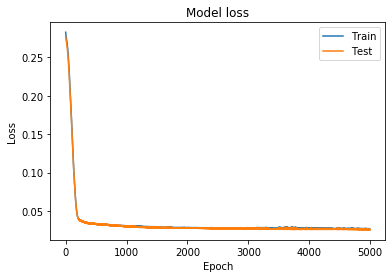

In [11]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right');
# plt.savefig("{}_learning_curve.png".format(model_name)

In [12]:
# K-Fold with the same hyperparameters
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
cvscores = []
component_cvscores = []
split = 1

for train_index, test_index in kfold.split(X, Y):
    
    model = Sequential([
        Dense(10, activation=tf.nn.relu, input_shape=(5,)),
        Dense(15, activation=tf.nn.relu),
        Dense(20, activation=tf.nn.relu),
        Dense(25, activation=tf.nn.relu),
        Dense(30, activation=tf.nn.relu),
        Dense(25, activation=tf.nn.relu),
        Dense(20, activation=tf.nn.relu),
        Dense(15, activation=tf.nn.relu),
        Dense(10, activation=tf.nn.relu),
        Dense( 4, activation=tf.nn.sigmoid)
    ])
        
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model.fit(X[train_index], Y[train_index], epochs=epochs,
              validation_split = 0.0, batch_size=X[train_index].shape[0], shuffle=False, verbose=0)
    scores = model.evaluate(X[test_index], Y[test_index], verbose=0)
    Y_pred = model.predict(X[test_index])
    component_cvscores.append(np.mean(np.absolute(Y_pred - Y[test_index]) / Y[test_index]*100, axis=0))
    print("Mean absolute percentage error (split{0}): {1}%".format(split, scores[1]))
    cvscores.append(scores[1])
    split += 1

print("{0}% (+/- {1}%)".format(np.mean(cvscores), np.std(cvscores))) 
print("Mean absolute percentage error for every component:", np.mean(component_cvscores, axis = 0), sep="\n")

Mean absolute percentage error (split1): 14.467738151550293%
Mean absolute percentage error (split2): 20.24471092224121%
Mean absolute percentage error (split3): 19.60133171081543%
Mean absolute percentage error (split4): 16.362781524658203%
Mean absolute percentage error (split5): 17.651399612426758%
17.665592193603516% (+/- 2.1129472255706787%)
Mean absolute percentage error for every component:
[16.39339149 11.38547182 13.21245865 29.67104986]
